In [1]:
library(plyr, quietly = TRUE)
library(tidyverse, quietly = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::desc()      masks plyr::desc()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [12]:
library(ggpubr)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




In [2]:
LLM_score_thresh = 0.8
enrichr_adj_pval_thresh = 0.05
enrichr_JI_thresh = 0.2

In [3]:
LLM_genes_DF = read_delim(file = "data/omics_revamped_LLM_Enrichr_simVals_DF.tsv", delim = "\t")

New names:
• `` -> `...1`
Rows: 11310 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (12): Source, GeneSetID, GeneSetName, GeneList, LLM Name, LLM Analysis, ...
dbl  (8): ...1, Unnamed: 0, n_Genes, Score, Rank, P-value, Adjusted P-value,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
get_JI = function(GeneList, enrichr_genes){
    # assume separation is the same
    geneSetGenes = str_split(string = GeneList, pattern = " ")[[1]]
    enrichRGenes = str_split(string = enrichr_genes, pattern = " ")[[1]]
    JI = length(intersect(geneSetGenes, enrichRGenes))/ length(union(geneSetGenes, enrichRGenes))
    
    return(JI)
    }
    

In [5]:
LLM_genes_DF = LLM_genes_DF %>%
rowwise() %>%
mutate(enrichr_JI = get_JI(GeneList, GO_term_genes))

In [6]:
LLM_genes_DF$GO_term_genes[1]

[1] "CES1 PNLIPRP1 PLA2G1B CES1P1 AOAH HSD17B14 APOA4 CYP3A4 PLAAT3 LIPC SIRT2 LIPG STS LIPE LCP1 LIPI CYP1A2 PPT1 PLA1A HSD11B1 PNLIP"

In [7]:
summary(LLM_genes_DF$enrichr_JI)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02033 0.02757 0.03129 0.03757 0.28571 

In [8]:
colnames(LLM_genes_DF)

[1] "...1"                 "Unnamed: 0"           "Source"              
 [4] "GeneSetID"            "GeneSetName"          "GeneList"            
 [7] "n_Genes"              "LLM Name"             "LLM Analysis"        
[10] "Score"                "Rank"                 "Overlap"             
[13] "P-value"              "Adjusted P-value"     "Genes"               
[16] "Term"                 "GO term"              "GO ID"               
[19] "GO_term_genes"        "LLM_name_GO_term_sim" "enrichr_JI"

In [9]:
LLM_genes_reduced_DF = LLM_genes_DF %>%
group_by("Source", "GeneSetID", "GeneSetName")

In [10]:
reduced_LLM_genes_DF = LLM_genes_DF %>%
group_by(Source, GeneSetID, GeneSetName, GeneList) %>%
slice(which.max(enrichr_JI))

In [11]:
dim(reduced_LLM_genes_DF)

[1] 300  21

In [12]:
reduced_LLM_genes_DF = reduced_LLM_genes_DF %>%
rowwise() %>%
mutate(enrichr_JI = get_JI(GeneList, GO_term_genes)) %>%
mutate(LLM_success_TF = ifelse(Score < 0.8, FALSE, TRUE),
       enrichr_success_TF = ifelse(((`Adjusted P-value` > enrichr_adj_pval_thresh) | (enrichr_JI < enrichr_JI_thresh)), FALSE, TRUE))

In [13]:
table(reduced_LLM_genes_DF[,c("LLM_success_TF", "enrichr_success_TF")])

              enrichr_success_TF
LLM_success_TF FALSE TRUE
         FALSE   167    0
         TRUE    129    4

In [16]:
write_delim(x = reduced_LLM_genes_DF, file = "data/omics_revamped_LLM_Enrichr_simVals_failure_DF.tsv", delim = "\t")

In [2]:
reduced_LLM_genes_DF = read_delim(file = "data/omics_revamped_LLM_Enrichr_simVals_failure_DF.tsv", delim = "\t")

Rows: 300 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (12): Source, GeneSetID, GeneSetName, GeneList, LLM Name, LLM Analysis, ...
dbl  (9): ...1, Unnamed: 0, n_Genes, Score, Rank, P-value, Adjusted P-value,...
lgl  (2): LLM_success_TF, enrichr_success_TF

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [23]:
colnames(reduced_LLM_genes_DF)

[1] "...1"                 "Unnamed: 0"           "Source"              
 [4] "GeneSetID"            "GeneSetName"          "GeneList"            
 [7] "n_Genes"              "LLM Name"             "LLM Analysis"        
[10] "Score"                "Rank"                 "Overlap"             
[13] "P-value"              "Adjusted P-value"     "Genes"               
[16] "Term"                 "GO term"              "GO ID"               
[19] "GO_term_genes"        "LLM_name_GO_term_sim" "enrichr_JI"          
[22] "LLM_success_TF"       "enrichr_success_TF"

In [33]:
reduced_LLM_genes_DF = reduced_LLM_genes_DF %>%
mutate(enrichr_adj_pVal = `Adjusted P-value`)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


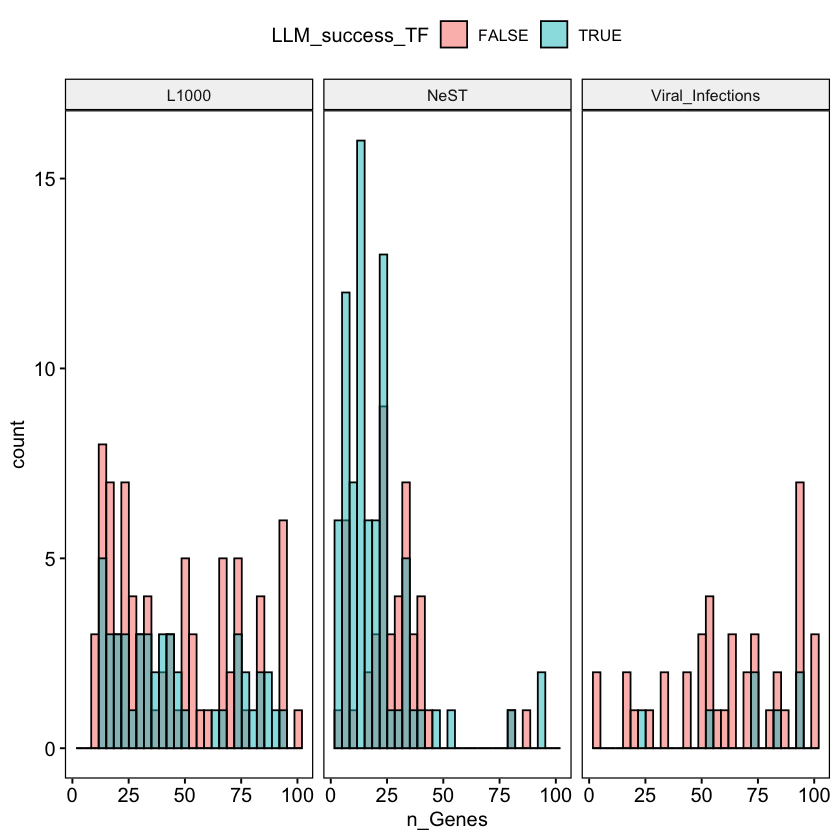

In [36]:
gghistogram(data =reduced_LLM_genes_DF, 
            x = "n_Genes",
           y = "count",
            facet.by = "Source", 
           fill = "LLM_success_TF")

In [37]:
table(reduced_LLM_genes_DF[,c("LLM_success_TF", "Source")])

              Source
LLM_success_TF L1000 NeST Viral_Infections
         FALSE    80   46               41
         TRUE     46   80                7

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


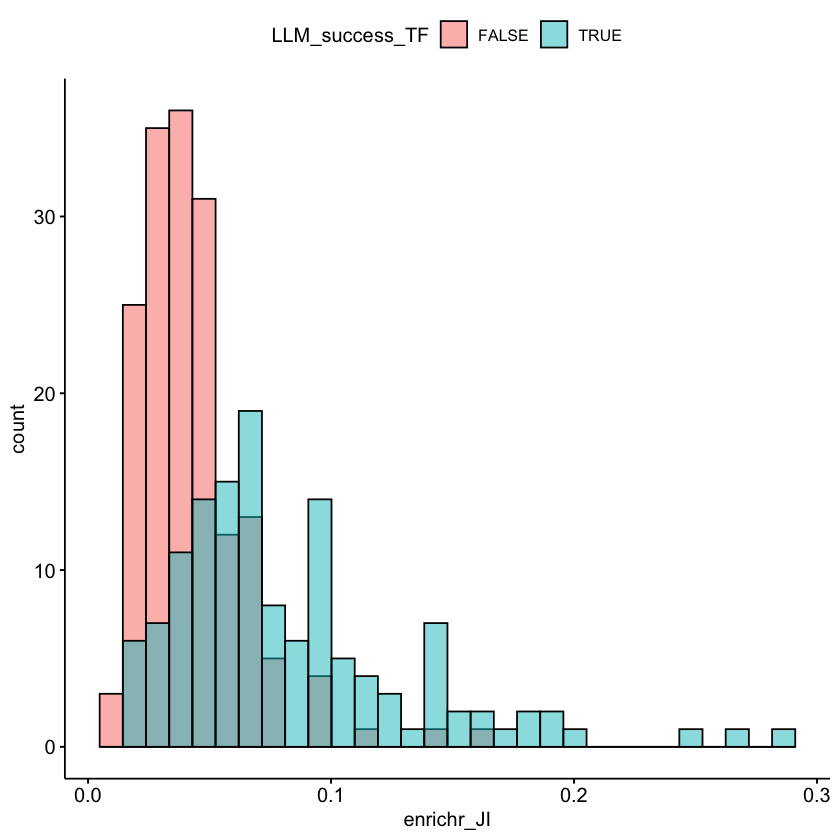

In [27]:
gghistogram(data =reduced_LLM_genes_DF, 
            x = "enrichr_JI",
           y = "count",
           fill = "LLM_success_TF")

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


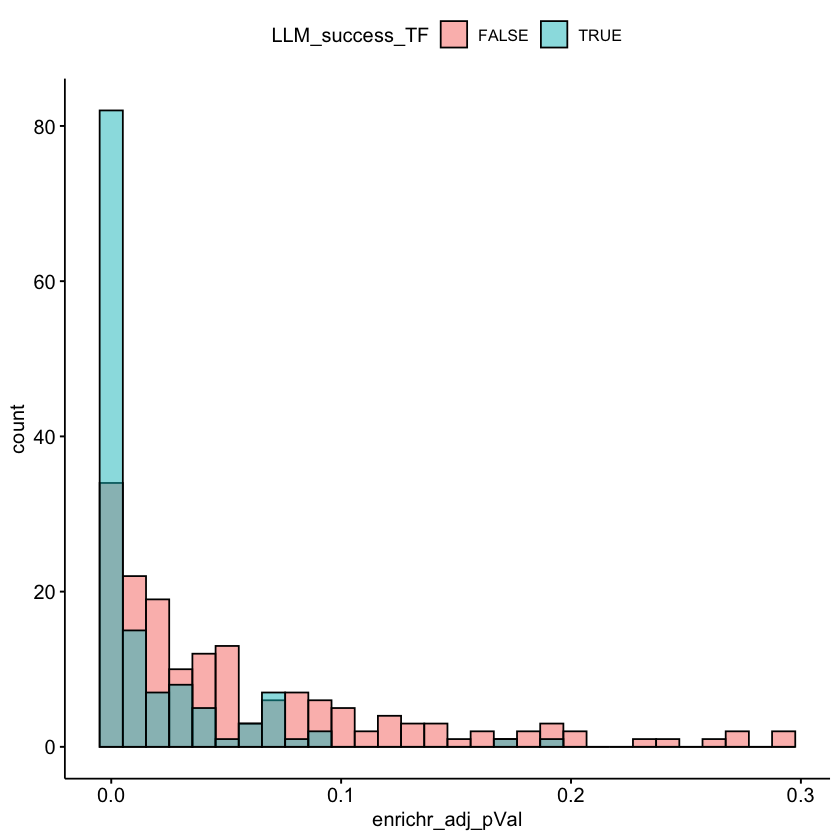

In [34]:
gghistogram(data =reduced_LLM_genes_DF, 
            x = "enrichr_adj_pVal",
           y = "count",
           fill = "LLM_success_TF")

In [32]:
typeof(reduced_LLM_genes_DF$`Adjusted P-value`)

[1] "double"

In [31]:
typeof(reduced_LLM_genes_DF$`enrichr_JI`)

[1] "double"

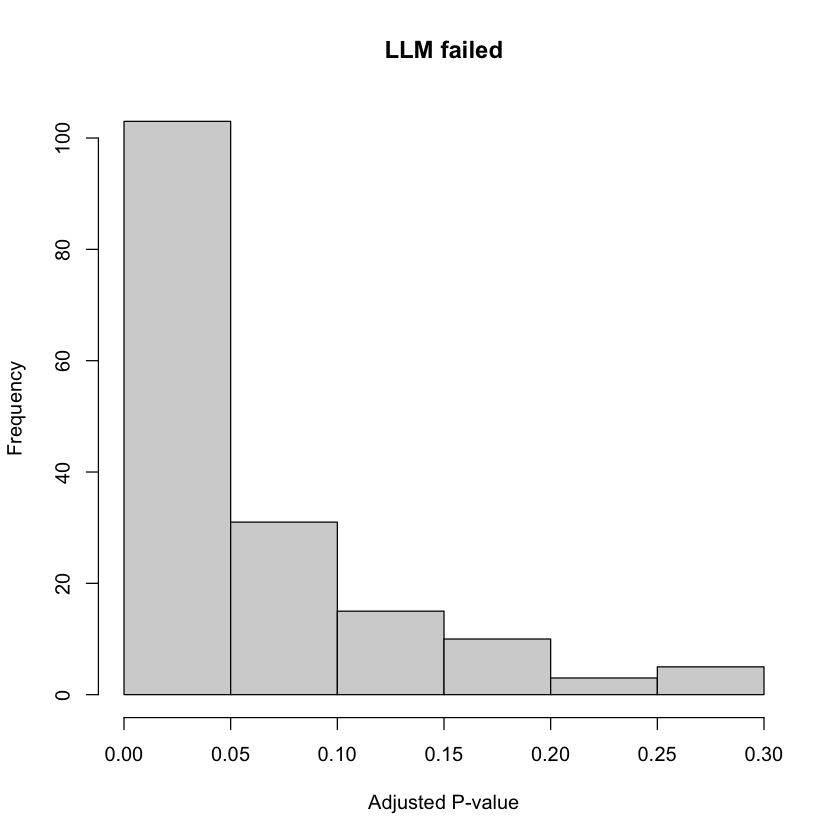

In [11]:
reduced_LLM_genes_DF %>%
subset(LLM_success_TF == FALSE) %>%
pull(`Adjusted P-value`) %>%
hist(xlab = "Adjusted P-value", main = "LLM failed")

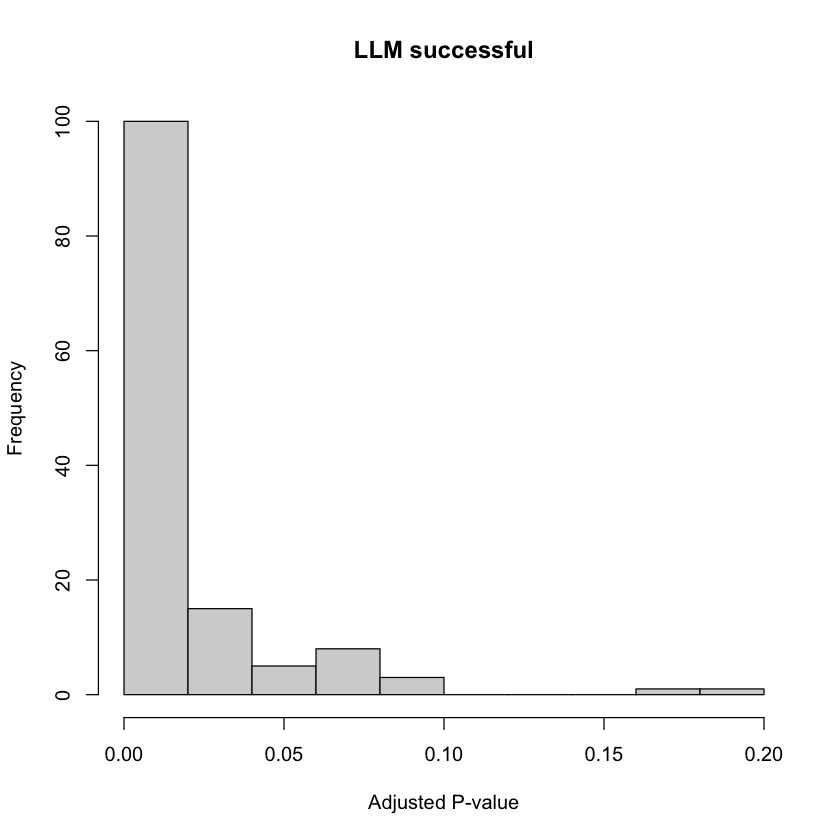

In [10]:
reduced_LLM_genes_DF %>%
subset(LLM_success_TF == TRUE) %>%
pull(`Adjusted P-value`) %>%
hist(xlab = "Adjusted P-value", main = "LLM successful")

In [15]:
129/(129+167)

[1] 0.4358108

In [9]:
reduced_LLM_genes_DF %>%
subset(LLM_success_TF == FALSE) %>%
count(Source)

Source,n
<chr>,<int>
L1000,80
NeST,46
Viral_Infections,41


In [ ]:
library(ggpubr)

In [ ]:
both_success_DF  =reduced_LLM_genes_DF %>%
subset(LLM_success_TF == TRUE

In [ ]:
hist_plot = gghistogram(data = both_success_DF, x = "LLM_name_GO_term_sim", y = "count", bins = 100)

In [ ]:
ggsave(filename = "figures/omics_revamped_test_hist_sim_LLM_GO_success.png", width = 5, height = 2)

In [ ]:
both_success_DF %>% subset(LLM_name_GO_term_sim > 0.8) %>% select(-"LLM Analysis") %>%
select(c("GeneSetName", "GeneList", "LLM Name", "Adjusted P-value", "GO term", "enrichr_JI"))  %>%
write_delim(file = "data/both_success_high_sim.txt", delim = "\t")

In [ ]:
both_success_DF %>% subset(LLM_name_GO_term_sim < 0.3) %>% select(-"LLM Analysis") %>%
select(c("GeneSetName", "GeneList", "LLM Name", "Adjusted P-value", "GO term", "enrichr_JI"))  %>%
write_delim(file = "data/both_success_low_sim.txt", delim = "\t")

In [ ]:
distribution of semantic similarty for both success

In [ ]:
similarity between LLM name and enrichr name for both success